# Graph Evolution

Graph evolution for given algorithms and dataset.

In [1]:
import os
import random
import time
import numpy as np
import networkx as nx

# local imports
import graph_evolution_metrics as metrics

# Seed for reproducibility
random.seed(42)

In [2]:
## CHANGE TO MATCH ALG AND DATASET

# Module of alg being used
import node2vec as alg
import random_removal_per_node as rm

from selection import SelectAll as Selector

# Name of dataset being used

# BASENAME, DIRECTED = "congress", True
# BASENAME, DIRECTED = "email_eu", True
# BASENAME, DIRECTED = "wiki_vote", True
BASENAME, DIRECTED = "facebook", False
# BASENAME, DIRECTED = "lastfm", False
# BASENAME, DIRECTED = "deezer", False

In [3]:
# Graph Evolution
ITERATIONS = 30

# Metrics
VISIBILITY_RATIO = 0.1

In [4]:
# Constants for I/O
INPUT_DIR = "../input"
OUTPUT_DIR = "../data"

OUTPUT_PREFIX = BASENAME + "." + alg.__name__

EDGELIST = BASENAME + ".txt"
MINORITIES = BASENAME + ".minorities"
EDGELIST_PATH = os.path.join(INPUT_DIR, EDGELIST)
MINORITIES_PATH = os.path.join(INPUT_DIR, MINORITIES)

In [5]:
init_g = nx.read_edgelist(EDGELIST_PATH, create_using=nx.DiGraph(), nodetype=int)

if not DIRECTED:
    # keep as DiGraph but add edges in opposite direction
    init_g.add_edges_from([(v, u) for u, v in init_g.edges()])

## Network Evolution Following Wagner's Methods

In [6]:
def add_edges(nx_g, edges):
    """
    Adds edges to given graph.
    """
    nx_g.add_edges_from(edges)
    if not DIRECTED:
        nx_g.add_edges_from([(v, u) for (u, v) in edges])


def remove_edges(nx_g, edges):
    """
    Removes edges from given graph.
    """
    nx_g.remove_edges_from(edges)
    if not DIRECTED:
        nx_g.remove_edges_from([(v, u) for (u, v) in edges])

    
# IMPORTANT: we do deletions to keep a baseline for the clustering coefficient and 
# see the effect of the algorithm on the graphs structure
def evolve_network(nx_g, minorities):
    """
    Iteratively evolve the network by adding and removing edges.
    """
    # initialize algorithm
    nx_g = alg.initialize(nx_g, directed=DIRECTED, protected=minorities)

    # initialize selection
    selector = Selector(nx_g, directed=DIRECTED, protected=minorities)

    # initialize recorder for metrics
    recorder = metrics.Recorder(directed=DIRECTED,
                                protected=minorities,
                                visibility_ratio=VISIBILITY_RATIO,
                                output_dir=OUTPUT_DIR,
                                output_prefix=OUTPUT_PREFIX)
    
    # initial metrics
    recorder.clear_files()
    recorder.record_metrics(nx_g)

    print("Iteration")
    print(f"0: {nx_g}")

    for i in range(1, ITERATIONS+1):

        to_predict = selector.nodes_to_predict(nx_g)

        predictions = alg.predict(nx_g, directed=DIRECTED, nodes=to_predict)
        add_edges(nx_g, predictions)

        to_remove = selector.nodes_to_remove(nx_g)

        removals = rm.removals(nx_g, directed=DIRECTED, nodes=to_remove)
        remove_edges(nx_g, removals)

        # compute metrics
        recorder.record_metrics(nx_g)
  
        if i % 2 == 0:
            print(f"{i}: {nx_g}")
    
    return recorder

In [7]:
minorities = []
with open(MINORITIES_PATH, "r") as f:
    for line in f:
        node = int(line.strip())
        minorities.append(node)

print(f"Minority size: {len(minorities)}")

Minority size: 606


In [8]:
# evolve the network
start = time.time()
recorder = evolve_network(init_g, minorities)
end = time.time()
print(f"Time elapsed: {end - start}")

Iteration
0: DiGraph with 4039 nodes and 176468 edges
2: DiGraph with 4039 nodes and 176476 edges
4: DiGraph with 4039 nodes and 176490 edges
6: DiGraph with 4039 nodes and 176500 edges
8: DiGraph with 4039 nodes and 176510 edges
10: DiGraph with 4039 nodes and 176512 edges
12: DiGraph with 4039 nodes and 176512 edges
14: DiGraph with 4039 nodes and 176516 edges
16: DiGraph with 4039 nodes and 176516 edges
18: DiGraph with 4039 nodes and 176516 edges
20: DiGraph with 4039 nodes and 176516 edges
22: DiGraph with 4039 nodes and 176518 edges
24: DiGraph with 4039 nodes and 176520 edges
26: DiGraph with 4039 nodes and 176520 edges
28: DiGraph with 4039 nodes and 176522 edges
30: DiGraph with 4039 nodes and 176522 edges
Time elapsed: 757.9676539897919


## Summary

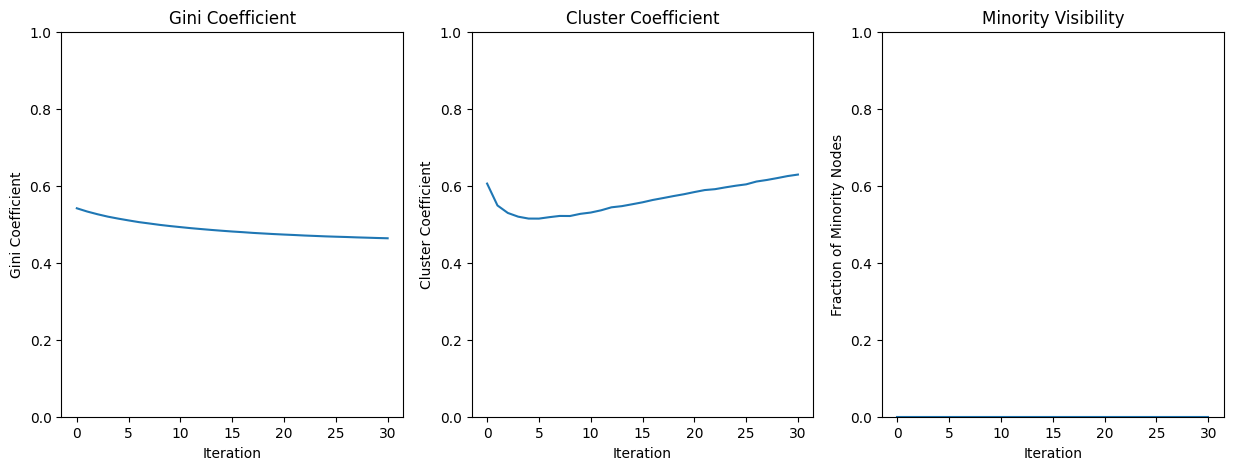

In [9]:
# plot data
recorder.plot_metrics()